<a href="https://www.kaggle.com/code/rahultheogre/modified-unet-on-rsna-pneumonia-dataset?scriptVersionId=111305990" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import csv
import random
import pydicom as dcm
import cv2
from pathlib import Path
from glob import glob
from matplotlib.patches import Rectangle
from tqdm.notebook import tqdm


import pandas as pd                                                 # for panel data analysis
pd.set_option('display.max_columns', None)                          # Unfolding hidden features if the cardinality is high      
pd.set_option('display.max_colwidth', None)                         # Unfolding the max feature width for better clrity      
pd.set_option('display.max_rows', None)                             # Unfolding hidden data points if the cardinality is high
pd.set_option('display.float_format', lambda x: '%.3f' % x)         # To suppress scientific notation over exponential values
#-------------------------------------------------------------------------------------------------------------------------------
import numpy as np                                                  # Importing package numpys (For Numerical Python)
#-------------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                                     # Importing pyplot interface using matplotlib
from matplotlib.pyplot import figure
figure(figsize=(15, 12), dpi=120)
from matplotlib.pylab import rcParams                               # Backend used for rendering and GUI integration                                               
import seaborn as sns                                               # Importing seaborn library for interactive visualization
#set seaborn plotting aesthetics
sns.set(style='whitegrid')
%matplotlib inline

In [2]:
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, SeparableConv2D, Conv2DTranspose, UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.callbacks import CSVLogger
import datetime

Number of images in train set is: 26684
Number of images in test set is: 3000
Total records for class information values: 30227
Distribution across the three possible classes


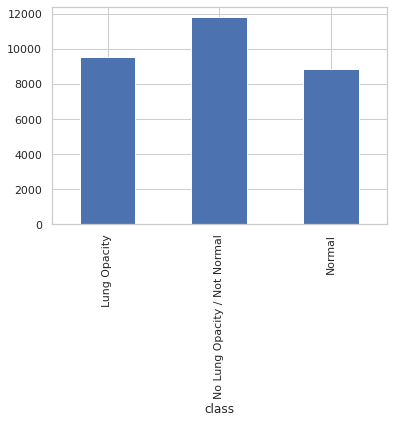

Total number of bounding boxes: 30227
Total patients as per train_class csv file: 26684
Total patients as per train labels csv file: 26684
Concatenating train_labels and train_class into train_meta
Number of images in train_meta 30227
Relationship of class and Target
                          class  Target  Patient Count
0                  Lung Opacity       1           9555
1  No Lung Opacity / Not Normal       0          11821
2                        Normal       0           8851
Creating train dataset without image information.
train_ds looks like:
                               patientId       x       y   width  height  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6     NaN     NaN     NaN     NaN   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd     NaN     NaN     NaN     NaN   
2  00322d4d-1c29-4943-afc9-b6754be640eb     NaN     NaN     NaN     NaN   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5     NaN     NaN     NaN     NaN   
4  00436515-870c-4b36-a041-de91049b9ab4 264.000 152.000 213.000 3

In [3]:
train_class = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')
train_labels = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')

train_path = Path('../input/rsna-pneumonia-detection-challenge/stage_2_train_images')
test_path = Path('../input/rsna-pneumonia-detection-challenge/stage_2_test_images')

print('Number of images in train set is:', len(os.listdir(train_path)))
print('Number of images in test set is:', len(os.listdir(test_path)))

print('Total records for class information values:', train_class.shape[0])

print('Distribution across the three possible classes')
train_class.groupby('class').size().plot.bar()
plt.show()

print('Total number of bounding boxes:', train_labels.shape[0])

print('Total patients as per train_class csv file:', train_class['patientId'].value_counts().shape[0])
print('Total patients as per train labels csv file:', train_labels['patientId'].value_counts().shape[0])


print('Concatenating train_labels and train_class into train_meta')
train_meta = pd.concat([train_labels, 
                        train_class.drop(columns=['patientId'])], axis=1)
print('Number of images in train_meta', len(train_meta))
print('Relationship of class and Target')
print(train_meta.groupby(['class', 'Target']).size().reset_index(name='Patient Count'))

box_df = train_meta.groupby('patientId').size().reset_index(name='boxes')

print('Creating train dataset without image information.')
train_ds = pd.merge(train_meta, box_df, on='patientId')
print('train_ds looks like:\n', train_ds.head())

print('Distribution of number of boxes in the lungs of each patient:')
box_df = box_df.groupby('boxes').size().reset_index(name='patients')
print(box_df)

print('Now we parse the information contained in DICOM images and add it to our train dataset')

# List of information we needs with us
vars = ['PatientAge','PatientSex','ImagePath']

#Functiont to process the metadata in the DICOM Images

def process_dicom_data(df, path):
    
    # adding new columns to the imported DataFrame with Null values
    for var in vars:
        df[var] = None
        
    images = os.listdir(path)
    
    #looping through each dicom image, extract the information from it, and 
    # add it to the DataFrame
    
    for i, img_name in tqdm(enumerate(images)):
        
        imagePath = os.path.join(path,img_name)
        img_data = dcm.read_file(imagePath)
        
        idx = (df['patientId']==img_data.PatientID)
        df.loc[idx,'PatientAge'] = pd.to_numeric(img_data.PatientAge)
        df.loc[idx,'PatientSex'] = img_data.PatientSex
        df.loc[idx, 'ImagePath'] = str.format(imagePath)

In [4]:
process_dicom_data(train_ds,'../input/rsna-pneumonia-detection-challenge/stage_2_train_images')
train_ds.to_csv('pneumonia_ds', index=False)

0it [00:00, ?it/s]

In [18]:
train_ds.head()

,patientId,x,y,width,height,Target,class,boxes,PatientAge,PatientSex,ImagePath
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,51,F,../input/rsna-pneumonia-detection-challenge/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,48,F,../input/rsna-pneumonia-detection-challenge/stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,19,M,../input/rsna-pneumonia-detection-challenge/stage_2_train_images/00322d4d-1c29-4943-afc9-b6754be640eb.dcm
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,1,28,M,../input/rsna-pneumonia-detection-challenge/stage_2_train_images/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm
4,00436515-870c-4b36-a041-de91049b9ab4,264.000,152.000,213.000,379.000,1,Lung Opacity,2,32,F,../input/rsna-pneumonia-detection-challenge/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm


In [19]:
sample_df = train_ds.\
    groupby(['Target','class', 'boxes']).\
    apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).\
    reset_index(drop=True)
sample_df

,patientId,x,y,width,height,Target,class,boxes,PatientAge,PatientSex,ImagePath
0,986237d6-e05f-4ce0-82e9-b81feb7fc399,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,33,F,../input/rsna-pneumonia-detection-challenge/stage_2_train_images/986237d6-e05f-4ce0-82e9-b81feb7fc399.dcm
1,b8b45d03-8161-4537-b5c5-a8f26299101c,NaN,NaN,NaN,NaN,0,Normal,1,52,F,../input/rsna-pneumonia-detection-challenge/stage_2_train_images/b8b45d03-8161-4537-b5c5-a8f26299101c.dcm
2,a03a2aab-7039-4743-9dab-3870899b1f35,650.000,689.000,279.000,316.000,1,Lung Opacity,1,58,M,../input/rsna-pneumonia-detection-challenge/stage_2_train_images/a03a2aab-7039-4743-9dab-3870899b1f35.dcm
3,03f8bb03-eb04-4365-ac4d-d63d2b5d49cc,65.000,154.000,300.000,573.000,1,Lung Opacity,2,46,M,../input/rsna-pneumonia-detection-challenge/stage_2_train_images/03f8bb03-eb04-4365-ac4d-d63d2b5d49cc.dcm
4,03f8bb03-eb04-4365-ac4d-d63d2b5d49cc,584.000,214.000,218.000,538.000,1,Lung Opacity,2,46,M,../input/rsna-pneumonia-detection-challenge/stage_2_train_images/03f8bb03-eb04-4365-ac4d-d63d2b5d49cc.dcm
5,6c490407-f039-4eaf-94c8-1bff41b09f6c,697.000,627.000,141.000,175.000,1,Lung Opacity,3,66,M,../input/rsna-pneumonia-detection-challenge/stage_2_train_images/6c490407-f039-4eaf-94c8-1bff41b09f6c.dcm
6,6c490407-f039-4eaf-94c8-1bff41b09f6c,188.000,621.000,158.000,146.000,1,Lung Opacity,3,66,M,../input/rsna-pneumonia-detection-challenge/stage_2_train_images/6c490407-f039-4eaf-94c8-1bff41b09f6c.dcm
7,6c490407-f039-4eaf-94c8-1bff41b09f6c,188.000,516.000,59.000,46.000,1,Lung Opacity,3,66,M,../input/rsna-pneumonia-detection-challenge/stage_2_train_images/6c490407-f039-4eaf-94c8-1bff41b09f6c.dcm
8,ee820aa5-4804-4984-97b3-f0a71d69702f,605.000,228.000,154.000,223.000,1,Lung Opacity,4,24,M,../input/rsna-pneumonia-detection-challenge/stage_2_train_images/ee820aa5-4804-4984-97b3-f0a71d69702f.dcm
9,ee820aa5-4804-4984-97b3-f0a71d69702f,634.000,569.000,193.000,175.000,1,Lung Opacity,4,24,M,../input/rsna-pneumonia-detection-challenge/stage_2_train_images/ee820aa5-4804-4984-97b3-f0a71d69702f.dcm


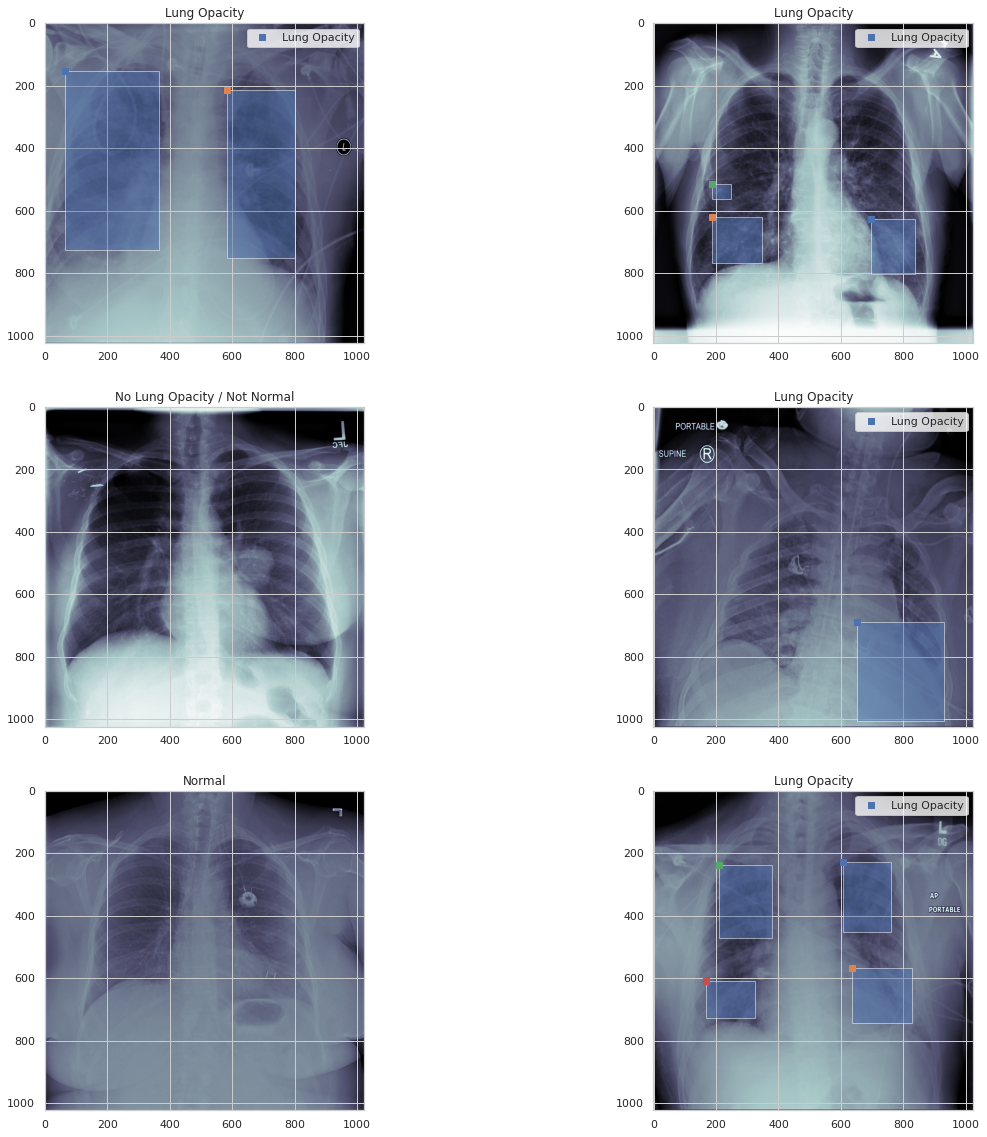

In [20]:
fig, m_axs = plt.subplots(3, 2, figsize = (20, 20))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['ImagePath'])):
    c_dicom = dcm.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()

In [10]:
print('Setting up a few hyperparameters')

SPLIT = 0.3
BATCH_SIZE = 64
IMG_HEIGHT = 180
IMG_WIDTH = 180
SEED = 42
NUM_CLASSES = 2

Setting up a few hyperparameters


In [21]:
print('We cannot use any of the predefined libraries for dealing with this data, as its possible labels are many. It is much easier to define ones function anyway')
print('So, we define an ImageDataFromDirectory class along with suitable functions')

class ImageDataFromDirectory():
    # Inherites keras.utils.Sequence for using functionalities such as multiprocessing
    #Generates data for Keras
    def __init__(self, folder_path, csv_path, validation_split, batch_size, seed, img_height=224, img_width=224, shuffle=True, validation= False):
        #Initialization
        self.batch_size = batch_size
        self.folder_path = folder_path
        self.csv_path = csv_path
        self.split = validation_split
        
        if validation == True:
          self.image_names = os.listdir(folder_path)
          random.seed(seed)
          random.shuffle(self.image_names)
          self.image_names = self.image_names[0:int(split*len(self.image_names))]
        else:
          self.image_names = os.listdir(folder_path)
          random.seed(seed)
          random.shuffle(self.image_names)
          self.image_names = self.image_names[int(split*len(self.image_names)):-1]
            
        self.img_height = img_height
        self.img_width = img_width
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_names) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.image_names[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_names))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, self.img_height, self.img_width, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, self.img_height, self.img_width, 2), dtype=np.float32)

        # Generate data
        for n, image_name in enumerate(list_IDs_temp):
            ds = dcm.dcmread(os.path.join(self.folder_path, image_name))
            pixel_array_numpy = ds.pixel_array
            x_img = pixel_array_numpy
            x_img = resize(x_img, (self.img_height, self.img_width, 1), mode = 'constant', preserve_range = True)

            # Draw masks
            sheet = open(self.csv_path, newline='')
            reader = csv.reader(sheet)
            mask = np.zeros((1024, 1024, 1), dtype = "uint8")

            image_name = os.path.splitext(image_name)[0]
            image_name = image_name.strip()

            for row in reader:
              if row[0]==image_name:
                if row[5]=='1':
                  pt1 = (int(row[1].split('.')[0]),int(row[2].split('.')[0]))
                  pt2 = (int(row[1].split('.')[0])+int(row[3].split('.')[0]),int(row[2].split('.')[0])+int(row[4].split('.')[0]))
                  cv2.rectangle(mask, pt1, pt2, 255, -1)     
            sheet.close()
            
            mask = resize(mask, (self.img_height, self.img_width, 1), mode = 'constant', preserve_range = True)
            mask.astype(int)
            mask /= 255.
            mask = tf.keras.utils.to_categorical(mask, num_classes=2, dtype='float32')
            #cv2_imshow(x_img)
            #cv2_imshow(mask)

            # Save images
            X[n] = x_img
            y[n] = mask

        return X, y

We cannot use any of the predefined libraries for dealing with this data, as its possible labels are many. It is much easier to define ones function anyway
So, we define an ImageDataFromDirectory class along with suitable functions


In [12]:
training_generator = ImageDataFromDirectory(folder_path='../input/rsna-pneumonia-detection-challenge/stage_2_train_images', 
                                            csv_path='../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv', 
                                            split=SPLIT, 
                                            batch_size=BATCH_SIZE,
                                            seed= SEED,
                                            validation=False)
    
validation_generator = ImageDataFromDirectory(folder_path='../input/rsna-pneumonia-detection-challenge/stage_2_train_images', 
                                            csv_path='../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv', 
                                            split=SPLIT, 
                                            batch_size=BATCH_SIZE,
                                            seed= SEED,
                                            validation=True)

print('We have created Training generator and validation generator data.')

We have created Training generator and validation generator data. Now let us visualize an image with and without mask.


### I need to create a matrix of various tuplen 

In [16]:
X_train, y_train = training_generator.__getitem__(2)

In [17]:
type(X_train)

numpy.ndarray

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.backend import flatten, sum, clear_session

In [ ]:
def dice_coef(y_true, y_pred):
  smooth = 1.0e-6
  y_true = flatten(y_true[:,:,:,1])
  y_pred = flatten(y_pred[:,:,:,1])
  intersection = sum(y_true * y_pred)
  union = sum(y_true) + sum(y_pred)
  
  score = 2*(intersection+smooth)/(union+smooth)
  return score
  
def DiceLoss(y_true, y_pred):
  score = dice_coef(y_true, y_pred)
  return 1 - score

In [ ]:
def modified_unet():
    inputs = Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(2)(x)

        # Project residual
        residual = UpSampling2D(2)(previous_block_activation)
        residual = Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
clear_session()